In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset, MonthEnd
from scipy.optimize import minimize



In [50]:
FILE = "treasury_quotes_2025-11-28.xlsx"   
SHEET = "selected quotes"
FACE = 100.0
USE_PERFECT_6M_GRID = True   


In [51]:
def add_months(d, months, eom=True):
    d = pd.Timestamp(d).normalize()
    new = d + DateOffset(months=months)
    return (new + MonthEnd(0)).normalize() if eom else new.normalize()

def spot_rate_sa_from_df(T, z):
    T = np.asarray(T, float)
    z = np.asarray(z, float)
    r = np.full_like(T, np.nan, dtype=float)
    mask = T > 0
    r[mask] = 2.0 * ((1.0 / z[mask]) ** (1.0 / (2.0 * T[mask])) - 1.0)
    return r

def spot_rate_cc_from_df(T, z):
    T = np.asarray(T, float)
    z = np.asarray(z, float)
    r = np.full_like(T, np.nan, dtype=float)
    mask = T > 0
    r[mask] = -np.log(z[mask]) / T[mask]
    return r

def ns_zero_rate_cc(T, beta0, beta1, beta2, tau):
    T = np.asarray(T, dtype=float)
    x = T / tau
    a = np.where(x == 0, 1.0, (1.0 - np.exp(-x)) / x)
    b = a - np.exp(-x)
    return beta0 + beta1 * a + beta2 * b

def df_from_cc_zero(T, y_cc):
    return np.exp(-y_cc * np.asarray(T, float))



In [52]:
df = pd.read_excel(FILE, sheet_name=SHEET)

required_cols = ["quote date", "issue date", "maturity date", "ttm", "cpn rate", "dirty price"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in '{SHEET}': {missing}")

quote_date = pd.Timestamp(df["quote date"].iloc[0]).normalize()

df = df.sort_values("ttm").reset_index(drop=True)
n = len(df)



In [ ]:

if not USE_PERFECT_6M_GRID:
    raise NotImplementedError("This script is set up for the perfect 6-month grid option.")

grid_start = pd.Timestamp(df["maturity date"].min()).normalize()
dates = [grid_start]
for _ in range(1, n):
    dates.append(add_months(dates[-1], 6, eom=True))


T = np.array([(pd.Timestamp(d).normalize() - quote_date).days for d in dates], dtype=float) / 365.25


C = np.zeros((n, n))
for j, r in df.iterrows():
    coupon = float(r["cpn rate"]) / 2.0
    for i in range(j + 1):
        C[j, i] = coupon + (FACE if i == j else 0.0)



In [54]:

p = df["dirty price"].astype(float).to_numpy()

if C.shape[0] == C.shape[1]:
    z_ols = np.linalg.solve(C, p)
else:
    z_ols, *_ = np.linalg.lstsq(C, p, rcond=None)



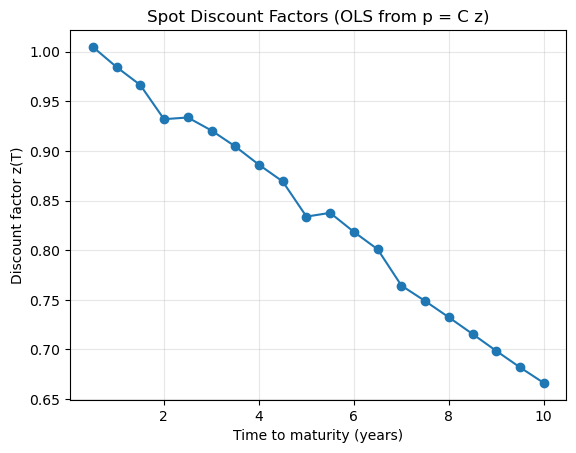

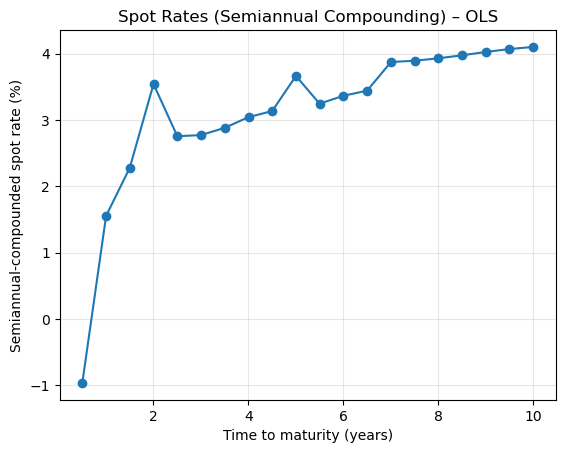

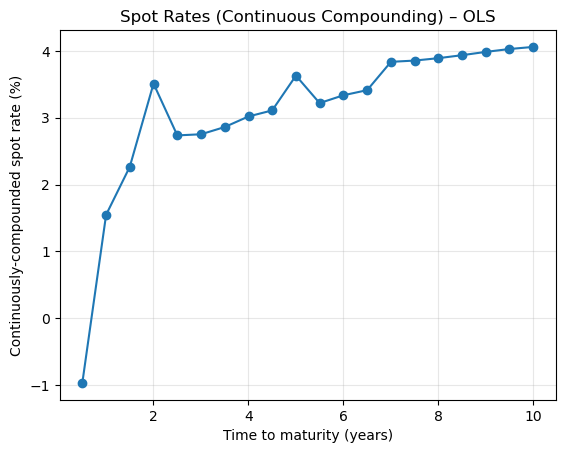

In [55]:

r_sa_ols = spot_rate_sa_from_df(T, z_ols)
r_cc_ols = spot_rate_cc_from_df(T, z_ols)

plt.figure()
plt.plot(T, z_ols, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Discount factor z(T)")
plt.title("Spot Discount Factors (OLS from p = C z)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(T, r_sa_ols * 100.0, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannual-compounded spot rate (%)")
plt.title("Spot Rates (Semiannual Compounding) – OLS")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(T, r_cc_ols * 100.0, marker="o")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Continuously-compounded spot rate (%)")
plt.title("Spot Rates (Continuous Compounding) – OLS")
plt.grid(True, alpha=0.3)
plt.show()




Nelson–Siegel parameter estimates (fit by SSE in prices):
  beta0 = 0.057244570
  beta1 = -0.039657695
  beta2 = -0.000092303
  tau   = 4.624147081
  SSE(price) = 12.056003 | success = True | msg = CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


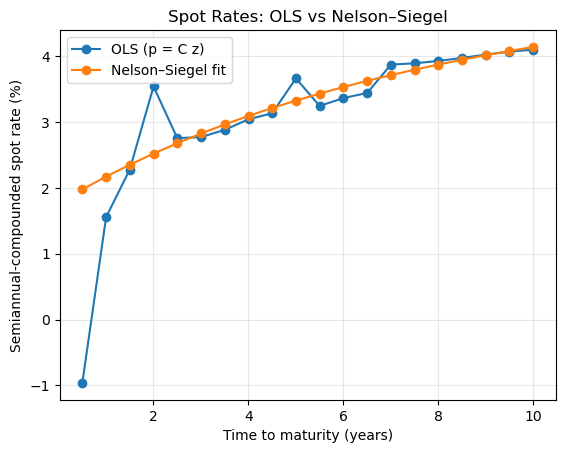

In [56]:

def sse_prices(x):
    beta0, beta1, beta2, log_tau = x
    tau = np.exp(log_tau) 
    y_cc = ns_zero_rate_cc(T, beta0, beta1, beta2, tau)
    z_ns = df_from_cc_zero(T, y_cc)
    p_model = C @ z_ns
    err = p_model - p
    return float(np.sum(err * err))

beta0_0 = float(np.nanmedian(r_cc_ols[-5:]))
x0 = np.array([beta0_0, -0.02, 0.02, np.log(2.0)], dtype=float)

bounds = [
    (-0.10, 0.20),                 # beta0
    (-0.50, 0.50),                 # beta1
    (-0.50, 0.50),                 # beta2
    (np.log(0.05), np.log(50.0)),  # log_tau  -> tau in (0.05, 50)
]

res = minimize(sse_prices, x0, method="L-BFGS-B", bounds=bounds)

beta0_hat, beta1_hat, beta2_hat, log_tau_hat = res.x
tau_hat = float(np.exp(log_tau_hat))

y_cc_hat = ns_zero_rate_cc(T, beta0_hat, beta1_hat, beta2_hat, tau_hat)
z_ns = df_from_cc_zero(T, y_cc_hat)
r_sa_ns = spot_rate_sa_from_df(T, z_ns)

print("\nNelson–Siegel parameter estimates (fit by SSE in prices):")
print(f"  beta0 = {beta0_hat:.9f}")
print(f"  beta1 = {beta1_hat:.9f}")
print(f"  beta2 = {beta2_hat:.9f}")
print(f"  tau   = {tau_hat:.9f}")
print(f"  SSE(price) = {res.fun:.6f} | success = {res.success} | msg = {res.message}")

plt.figure()
plt.plot(T, r_sa_ols * 100.0, marker="o", label="OLS (p = C z)")
plt.plot(T, r_sa_ns  * 100.0, marker="o", label="Nelson–Siegel fit")
plt.xlabel("Time to maturity (years)")
plt.ylabel("Semiannual-compounded spot rate (%)")
plt.title("Spot Rates: OLS vs Nelson–Siegel")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()





In [57]:

out = pd.DataFrame({
    "date": pd.to_datetime(dates).date,
    "ttm_years": T,
    "z_ols": z_ols,
    "r_sa_ols": r_sa_ols,
    "r_cc_ols": r_cc_ols,
    "z_ns": z_ns,
    "r_sa_ns": r_sa_ns,
})
print("\nCurve points (head):")
print(out.head(10).to_string(index=False))


Curve points (head):
      date  ttm_years    z_ols  r_sa_ols  r_cc_ols     z_ns  r_sa_ns
2026-05-31   0.503765 1.004878 -0.009636 -0.009659 0.990142 0.019763
2026-11-30   1.004791 0.984562  0.015544  0.015484 0.978539 0.021708
2027-05-31   1.503080 0.966520  0.022784  0.022655 0.965476 0.023512
2027-11-30   2.004107 0.932065  0.035414  0.035104 0.951041 0.025205
2028-05-31   2.505133 0.933755  0.027548  0.027360 0.935516 0.026786
2028-11-30   3.006160 0.920573  0.027720  0.027530 0.919092 0.028263
2029-05-31   3.504449 0.904592  0.028818  0.028612 0.902038 0.029637
2029-11-30   4.005476 0.886086  0.030423  0.030194 0.884319 0.030929
2030-05-31   4.503765 0.869313  0.031340  0.031097 0.866263 0.032132
2030-11-30   5.004791 0.833874  0.036631  0.036300 0.847792 0.033266
